This notebook finds the closest infrastructure to the points chosen by the WK-Means algorithm.

Install & import libraries

In [ ]:
!pip install mapbox==0.3.1
!pip install geopandas

In [8]:
import geopandas
import pickle
import pandas as pd
import geopy.distance
from mapbox import Geocoder
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Set API Token

In [4]:
mapbox_token = 'pk.eyJ1Ijoiamw4NzgxNyIsImEiOiJja244emZ6YjMwZWR0Mm9waWh0d3FpY24zIn0.d4S4s9v5PE93-J3othM21g'
geocoder = Geocoder(access_token=mapbox_token)

Read in WK-Means centroids

In [9]:
pop_centroids = pd.read_pickle('/content/pop_centroids.pkl')
demo_centroids = pd.read_pickle('/content/demo_centroids.pkl')
income_centroids = pd.read_pickle('/content/income_centroids.pkl')

Calculate Geodesic Distance for WGS84 Ellipsoid

In [141]:
# takes tuple (lat,lon) as coord
def geodesic_distance(coord1,coord2):
  return geopy.distance.distance(coord1, coord2).m

Convert geojson to dataframe & calculate distances

In [308]:
def geojson_to_df(geojson, point):

  df = geopandas.GeoDataFrame(geojson['features'])
  df = df[['place_name','center','properties']]
  df.columns = ['name','coordinates','properties']
  df['new_coord'] = [tuple(x[::-1]) for x in tuple(df['coordinates'])]
  types = [i['category'].split(',')[0] if 'category' in i else 'unknown' for i in df['properties']]
  df['type'] = types

  df['distance'] = df.apply(lambda x: geodesic_distance(point,x.coordinates),axis=1)
  df = df.sort_values('distance')
  df = df.drop('properties',axis=1)
  df['old_lat'] = point[0]
  df['old_lon'] = point[1]
  return df

Search for nearby infrastructure

In [ ]:
locations = []
for idx,i in enumerate(pop_centroids['lon']):
  point = (pop_centroids['lat'][idx], pop_centroids['lon'][idx])

  med_center = geocoder.forward(address="medical center", lon=pop_centroids['lon'][idx], lat=pop_centroids['lat'][idx]).geojson()
  mdf = geojson_to_df(med_center,point)  

  pharmacy = geocoder.forward(address="pharmacy", lon=pop_centroids['lon'][idx], lat=pop_centroids['lat'][idx]).geojson()
  pdf = geojson_to_df(pharmacy,point)

  grocery = geocoder.forward(address="grocery", lon=pop_centroids['lon'][idx], lat=pop_centroids['lat'][idx]).geojson()
  gdf = geojson_to_df(grocery,point)

  com_center = geocoder.forward(address="community center", lon=pop_centroids['lon'][idx], lat=pop_centroids['lat'][idx]).geojson()
  cdf = geojson_to_df(com_center,point)

  church = geocoder.forward(address="church", lon=pop_centroids['lon'][idx], lat=pop_centroids['lat'][idx]).geojson()
  churchdf = geojson_to_df(church,point)

  school = geocoder.forward(address="school", lon=pop_centroids['lon'][idx], lat=pop_centroids['lat'][idx]).geojson()
  sdf = geojson_to_df(school,point)

  uni = geocoder.forward(address="university", lon=pop_centroids['lon'][idx], lat=pop_centroids['lat'][idx]).geojson()
  udf = geojson_to_df(uni,point)

  college = geocoder.forward(address="college", lon=pop_centroids['lon'][idx], lat=pop_centroids['lat'][idx]).geojson()
  collegedf = geojson_to_df(college,point) 

  clinic = geocoder.forward(address="clinic", lon=pop_centroids['lon'][idx], lat=pop_centroids['lat'][idx]).geojson()
  clinicdf = geojson_to_df(clinic,point)

  hospital = geocoder.forward(address="hospital", lon=pop_centroids['lon'][idx], lat=pop_centroids['lat'][idx]).geojson()
  hdf = geojson_to_df(hospital,point) 
 
  all = [pdf,gdf,cdf,churchdf,sdf,clinicdf,hdf,mdf,udf,collegedf]
  df = pd.concat(all).reset_index().drop('index',axis=1)
  df = df.sort_values('distance')
  best = df.iloc[0].values
  locations.append(best)

Display the closest infrastructure to the initial WK-Means points

In [339]:
final_points = pd.DataFrame(locations, columns=['name','coordinates','type','dist','lat_from','lon_from'])
new_lat = [i[0] for i in final_points.coordinates ]
new_lon = [i[1] for i in final_points.coordinates ]
final_points['new_lat'] = new_lat
final_points['new_lon'] = new_lon
final_points = final_points.drop('coordinates',axis=1)
final_points

,name,type,dist,lat_from,lon_from,new_lat,new_lon
0,"Rite Aid, 250 W Chase St, Baltimore, Maryland ...",pharmacy,50.723710,39.301688,-76.620319,39.301823,-76.619757
1,"Futurecare, 22 S Athol Ave, Baltimore, Marylan...",clinic,269.389512,39.287039,-76.689013,39.284934,-76.690566
2,"Digital Harbor High School, 1100 Covington St,...",high school,158.936402,39.277072,-76.605698,39.276606,-76.607439
3,"First St. Stephens Baptist Church, 4663 Pimlic...",church,131.746504,39.343695,-76.668424,39.344804,-76.667880
4,"B. Green Wholesale, 1300 S Monroe St, Baltimor...",grocery,552.720937,39.276508,-76.645560,39.273492,-76.640463
5,"John Ruhrah Elementary, 701 Rappolla St, Balti...",elementary school,227.213282,39.283236,-76.554014,39.284476,-76.551919
6,"Keswick Multi-care Center, 700 W 40th St, Balt...",hospital,431.812120,39.341744,-76.631612,39.338135,-76.629744
7,"Redemption Church, 4400 Parkside Dr, Baltimore...",church,590.803103,39.319615,-76.560030,39.324808,-76.561529
8,"St. Matthew Catholic Church, 5401 Loch Raven B...",church,681.811373,39.356467,-76.597414,39.355755,-76.589557
9,"Giant Food, 601 E 33rd St, Baltimore, Maryland...",supermarket,331.491264,39.325764,-76.605436,39.328192,-76.607673


Plot the differences in distance between old points & new points

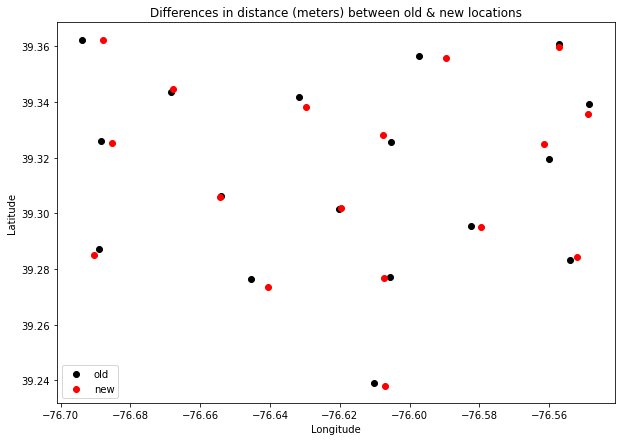

In [341]:
from matplotlib import pyplot as plt
old_lon = pop_centroids['lon'].values
old_lat = pop_centroids['lat'].values
new_lon = final_points['new_lon'].values
new_lat = final_points['new_lat'].values


fig, ax = plt.subplots(figsize=(10,7));
#white = ax.scatter(lon4,lat4, c='white');
black = ax.scatter(old_lon,old_lat,c='black'); 
red = ax.scatter(new_lon,new_lat,c='red'); 
ax.legend((black,red),('old','new'));
plt.title('Differences in distance (meters) between old & new locations');
plt.xlabel('Longitude');
plt.ylabel('Latitude');

Save results as pickle file

In [340]:
final_points.to_pickle('/content/pop_final_points.pkl')
